# Loading neuropixels data from the Jaramillo lab

## Copy the data to your workstation
Things work best if you store the data using the same directory structure we use.
1. You can download an example dataset from [Dropbox/jaralab_neuropixels_data](https://www.dropbox.com/sh/3mhnbkp455p2bea/AADYIjAkMbZNqVnF41-R_nKOa?dl=0).
1. The dataset contains three folders:
    * `neuropixels`: contains the spikes and synchronization events. One subfolder for each animal.
    * `behavior`: contains the stimulus parameters and timing used on each session. One subfolder for each animal.
    * `databases`: contains databases with the metadata about each recorded neuron.

## Install the necessary Python packages
You need to install the package [jaratoolbox](https://github.com/sjara/jaratoolbox) to read these datasets and perfomed basic analysis.
* The installation instructions in the `README.txt` are specific to our lab, but they should provide sufficient information for installing it in other systems.
* If you want to run this package inside a **virtual environment**, you need to create the environment before following the installation instructions.
* Make sure you edit your `settings.py` file so paths point to the correct locations where data is stored in your machine. In particular, you need:
   * `EPHYS_NEUROPIX_PATH = '/YOUR_DATA_FOLDER/neuropixels'`
   * `BEHAVIOR_PATH = '/YOUR_DATA_FOLDER/behavior/'`
   * `DATABASE_PATH = '/YOUR_DATA_FOLDER/databases/'`


## Load a database of cells
The code below loads the database of cells (a pandas DataFrame) for mouse `feat007`.

In [1]:
import os
from jaratoolbox import settings
from jaratoolbox import celldatabase

subject = 'feat007'
studyName = '2022paspeech'
dbPath = os.path.join(settings.DATABASE_PATH, studyName, f'celldb_{subject}.h5')
celldb = celldatabase.load_hdf(dbPath)

Each row contains the information about one cell. Here is an example:

In [2]:
celldb.iloc[0]

behavSuffix                                                  [a, b, a]
bestChannel                                                          0
brainArea                                                     AC_right
cluster                                                              0
cluster_label                                                     good
date                                                        2022-03-10
egroup                                                               0
ephysTime                               [11-19-31, 11-27-37, 11-44-02]
info                                     [anteromedial_DiI, soundLeft]
maxDepth                                                          2967
paradigm               [am_tuning_curve, am_tuning_curve, 2afc_speech]
pdepth                                                            2967
probe                                                        NPv1-8131
recordingSiteName                 Temporal association areas, layer 6a
record

In these recordings, there are three types of sessions: (1) AM sounds, (2) pure tones, and (3) speech sounds.

In [3]:
celldb.sessionType[0]

['AM', 'pureTones', 'FTVOTBorders']

Here is an overview of the stimuli used in each case:
* **AM:** 500ms AM noise, 11 modulation rates (4–128Hz), one intensity 60dB
* **pureTones**: 100ms tone pips, 16 frequencies (2kHz–4kHz), two intensities 60dB and 70dB.
* **FTVOTBorders**: This presents the "borders" of the 4x4 matrix of possible FT x VOT combinations. This includes the following combinations:
    * [ VOT000, VOT033, VOT067, VOT100 ] for [ FT000, FT100 ]
    * [ FT000, FT033, FT067, FT100 ] for [ VOT000, VOT100 ]

## Load data from one cell
Load the spike data from one cell.

In [4]:
from jaratoolbox import ephyscore

dbRow = celldb.iloc[12]  # Get metadata for one cell in database
oneCell = ephyscore.Cell(dbRow)  # The Cell object has methods for loading specific data sessions 
ephysData, bdata = oneCell.load('AM') # Load data for session with AM sounds

The code above loaded the spike data (`ephysData`) and stimulus data, which we call behavior data (`bdata`). Both of these are dictionary-like objects. Each key in `bdata` contains an array of length equal to the number of trials.

In [5]:
ephysData.keys()

dict_keys(['spikeTimes', 'events', 'clusterEachSpike'])

In [6]:
bdata.keys()

dict_keys(['currentAmpL', 'currentAmpR', 'currentFreq', 'currentIntensity', 'delayToSyncLight', 'isi', 'isiHalfRange', 'isiMean', 'laserBackOverhang', 'laserFrontOverhang', 'laserTrial', 'laserTrialsFraction', 'maxFreq', 'maxInt', 'minFreq', 'minInt', 'numInt', 'numTones', 'randomMode', 'soundLocation', 'stimDur', 'stimType', 'syncLight', 'syncLightDuration'])

**IMPORTANT:** The number of stimulus presentations collected by the ephys system is usually one higher than the number of stimuli stored from the behavior system. This is because the behavior system only stores trials that fully completed (and the user usually stops the presentation half-way through a trial).

In [7]:
nTrialsEphys = len(ephysData['events']['stimOn'])
print(nTrialsEphys)

222


In [8]:
nTrialsBehavior = len(bdata['currentFreq'])
print(nTrialsBehavior)

221


## Align spike data to events
The first step in the analysis is usually to grab a window around the time of each stimulus presentation.

In [9]:
from jaratoolbox import spikesanalysis

nTrials = len(bdata['currentFreq'])
spikeTimes = ephysData['spikeTimes']
eventOnsetTimes = ephysData['events']['stimOn'][:nTrials] # Ignore trials not in bdata 
timeRange = [-0.5, 1]  # In seconds

(spikeTimesFromEventOnset, trialIndexForEachSpike, indexLimitsEachTrial) = \
    spikesanalysis.eventlocked_spiketimes(spikeTimes, eventOnsetTimes, timeRange)

We won't go into details of what these arrays contain, but the names give you an idea of how we store the aligned data.

## Find the trials for each stimulus type
Now we want to group trials according to what stimulus was presented, so we can compare neural firing across stimuli.

In [10]:
import numpy as np
from jaratoolbox import behavioranalysis

currentStim = bdata['currentFreq']
possibleStim = np.unique(currentStim)
trialsEachCond = behavioranalysis.find_trials_each_type(currentStim, possibleStim)

The last line creates a boolean array of size [nTrials, nPossibleStim], where each column indicates which trials contained a particular stimulus type.

In [11]:
trialsEachCond.shape

(221, 11)

## Plotting a spike raster-plot grouped by stimulus type
We have a function that uses the boolean array created above (`trialsEachCond`) and the aligned spike data `spikeTimesFromEventOnset` and `indexLimitsEachTrial`) to plot a raster plot groups by stimulus condition.

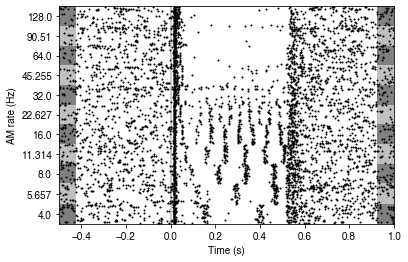

In [12]:
import matplotlib.pyplot as plt
from jaratoolbox import extraplots

rasterTimeRange = [-0.5, 1]  # In seconds
pRaster, hcond, zline = extraplots.raster_plot(spikeTimesFromEventOnset, indexLimitsEachTrial, 
                                               rasterTimeRange, trialsEachCond, labels=possibleStim)
plt.setp(pRaster, ms=2)
plt.xlabel('Time (s)');
plt.ylabel('AM rate (Hz)');

## Loading simultaneously recorded cells
For analysis of simultaneously recorded cell populations, we don't want to load one cell at a time, since that means we would be loading the same thing (behavior data, events, etc) multiple times. Instead, we use the class `ephyscore.CellEnsemble()`. 

First, we create a database that contains cells recorded on a single experiment:

In [13]:
sessionDate = '2022-03-10'
probeDepth = 2967
celldbSubset = celldb[(celldb.date==sessionDate) & (celldb.pdepth==probeDepth)]

Then, we create the `CellEnsemble` object and load the data for one session:

In [14]:
ensemble = ephyscore.CellEnsemble(celldbSubset)
ephysData, bdata = ensemble.load('AM')

Here, `ephysData` contains the spike times for all cells combined, so we need to extract those from each cell, which we can do efficiently with `ephyscore.CellEnsemble.get_spiketimes(clusterID)`. One option would be to create a list of arrays with the spike times for each cell. However, what we really need is to align all the cells to the stimulus onset. Here is how we can do so:

In [15]:
nTrials = len(bdata['currentFreq'])
eventOnsetTimes = ephysData['events']['stimOn'][:nTrials] # Ignore trials not in bdata 
timeRange = [-0.5, 1]  # In seconds

spikeTimesFromEventOnsetAll, trialIndexForEachSpikeAll, indexLimitsEachTrialAll = \
    ensemble.eventlocked_spiketimes(eventOnsetTimes, timeRange)

Now we need an efficient way to group spikes from each trial according to the trial types.

In [16]:
currentStim = bdata['currentFreq']
possibleStim = np.unique(currentStim)
trialsEachCond = behavioranalysis.find_trials_each_type(currentStim, possibleStim)
nTrialsEachCond = trialsEachCond.sum(axis=0)  # Not used, but in case you need it

# Here we create sorting array to be used later.
condEachSortedTrial, sortedTrials = np.nonzero(trialsEachCond.T)
sortingInds = np.argsort(sortedTrials)  # This will be used to sort trialIndexForEachSpike

Let's plot the rasters (with trials sorted by stimulus type) for a subset of cells.

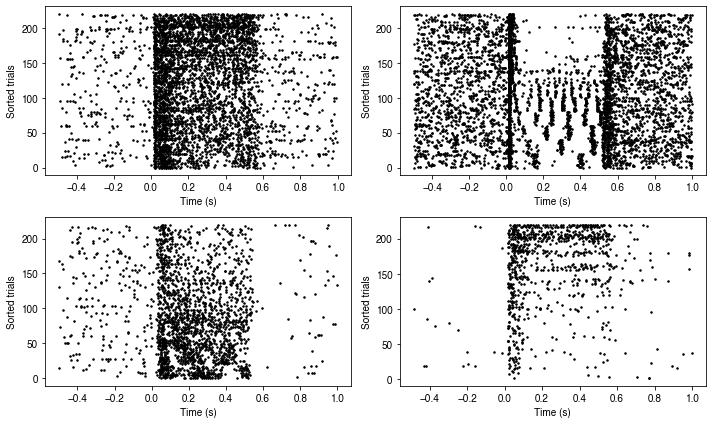

In [17]:
import matplotlib.pyplot as plt

someCells = [7, 12, 14, 9]
fig = plt.figure(figsize=[10, 6])
for count, indcell in enumerate(someCells):
    # And here is where we use the sorting array.
    sortedIndexForEachSpike = sortingInds[trialIndexForEachSpikeAll[indcell]]
    plt.subplot(2, 2, count+1)
    plt.plot(spikeTimesFromEventOnsetAll[indcell], sortedIndexForEachSpike, '.k', ms=3)
    plt.xlabel('Time (s)')
    plt.ylabel('Sorted trials')
plt.tight_layout()

## Quantifying spike counts
Let's calculate how many spikes occured in each 5ms bin.

In [18]:
binSize = 0.005
binEdges = np.arange(timeRange[0], timeRange[1], binSize)
spikeCount = ensemble.spiketimes_to_spikecounts(binEdges)
spikeCount.shape  # The shape is (nCells, nTrials, nBins)

(71, 221, 299)

We can easily sort this array according to trial type using `sortedTrials` calculated earlier.

In [19]:
sortedSpikeCount = spikeCount[:, sortedTrials, :] 

Here is how the sorted spike count array (sorted by trial type) looks like:

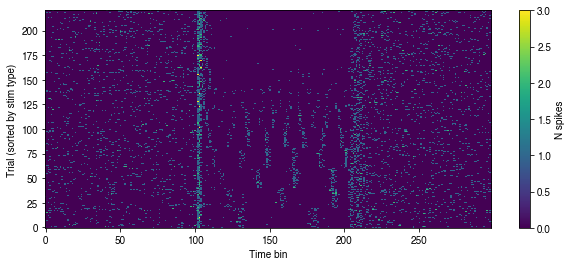

In [20]:
fig = plt.figure(figsize=[10, 4])
cellToPlot = 12
plt.imshow(sortedSpikeCount[cellToPlot], aspect='auto', origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Trial (sorted by stim type)')
plt.colorbar(label='N spikes');

And from these arrays, it's easy to calculate a peri-stimulus time histogram (PSTH) for each trial type:

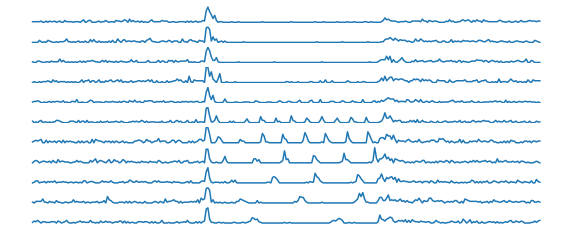

In [21]:
fig = plt.figure(figsize=[10, 4])
nCond = trialsEachCond.shape[1]
for indcond, trialsThisCond in enumerate(trialsEachCond.T):
    PSTH = spikeCount[cellToPlot, trialsThisCond, :].mean(axis=0)
    plt.subplot(nCond, 1, nCond-indcond)
    plt.axis(False)
    plt.plot(PSTH)